Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/20] - Loss: 1.8126 - Train Acc: 35.05% - Val Acc: 43.23%
Epoch [2/20] - Loss: 1.6496 - Train Acc: 41.88% - Val Acc: 46.30%
Epoch [3/20] - Loss: 1.5767 - Train Acc: 44.54% - Val Acc: 48.49%
Epoch [4/20] - Loss: 1.5268 - Train Acc: 46.16% - Val Acc: 48.92%
Epoch [5/20] - Loss: 1.4960 - Train Acc: 47.29% - Val Acc: 50.92%
Epoch [6/20] - Loss: 1.4586 - Train Acc: 48.50% - Val Acc: 49.87%
Epoch [7/20] - Loss: 1.4299 - Train Acc: 49.73% - Val Acc: 50.68%
Epoch [8/20] - Loss: 1.3944 - Train Acc: 50.66% - Val Acc: 50.70%
Epoch [9/20] - Loss: 1.3779 - Train Acc: 51.19% - Val Acc: 51.57%
Epoch [10/20] - Loss: 1.3608 - Train Acc: 51.83% - Val Acc: 51.38%
Epoch [11/20] - Loss: 1.3347 - Train Acc: 52.71% - Val Acc: 52.72%
Epoch [12/20] - Loss: 1.3104 - Train Acc: 53.73% - Val Acc: 53.07%
Epoch [13/20] - Loss: 1.3027 - Train Acc: 54.07% - Val Acc: 52.61%
Epoch [14/20] - Loss: 1.2717 - Train Acc: 54.85% 

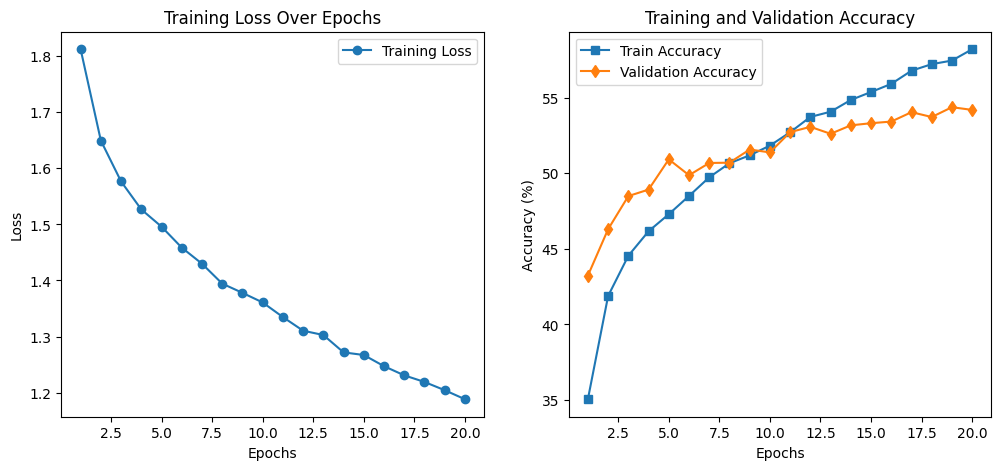


Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.63      0.62      1000
           1       0.70      0.61      0.65      1000
           2       0.42      0.42      0.42      1000
           3       0.38      0.34      0.36      1000
           4       0.43      0.50      0.46      1000
           5       0.44      0.38      0.41      1000
           6       0.61      0.61      0.61      1000
           7       0.68      0.58      0.62      1000
           8       0.57      0.76      0.66      1000
           9       0.61      0.58      0.60      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000



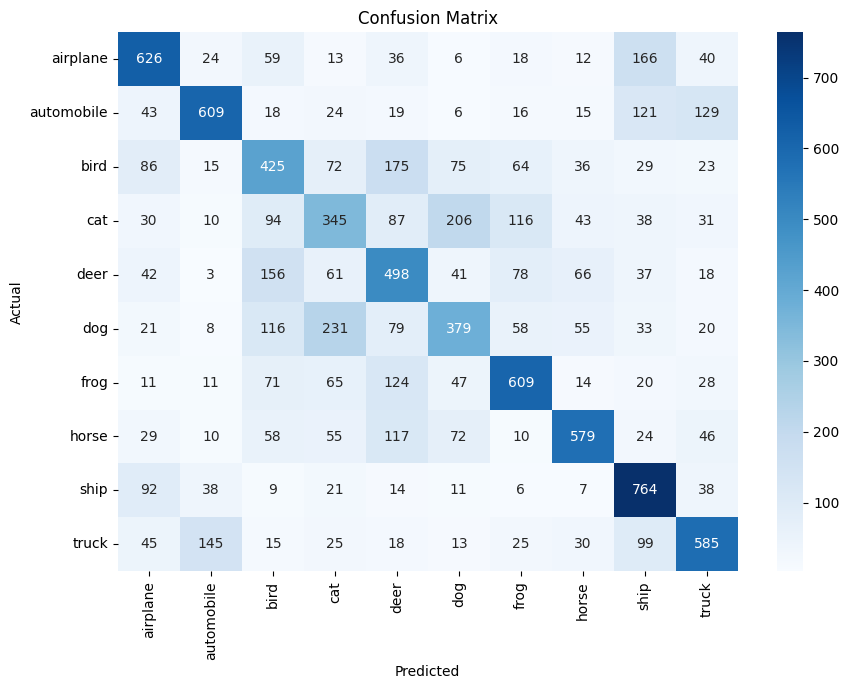


Model saved successfully as 'mlp_cifar10.pth'.


In [3]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))  # Normalization for CIFAR-10
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Define Multi-Layer Perceptron (MLP) Model
class MLP(nn.Module):
    def __init__(self, input_dim=32*32*3, hidden_dims=[512, 256, 128], output_dim=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout to reduce overfitting

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

          # Initialize model, loss function, and optimizer
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

     # Training loop
epochs = 20
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

          # Validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_losses[-1]:.4f} - Train Acc: {train_accuracies[-1]:.2f}% - Val Acc: {val_accuracies[-1]:.2f}%")

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, marker='s', label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, marker='d', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

# Evaluate model on test set
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Display classification report
print("\nClassification Report:\n", class_report)

    # Show confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

      # Save model
torch.save(model.state_dict(), "mlp_cifar10.pth")
print("\nModel saved successfully as 'mlp_cifar10.pth'.")
